### Problem Statement

The data scientists at BigMart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and find out the sales of each product at a particular store.Using this model, BigMart will try to understand the properties of products and stores which play a key role in increasing sales.

**Please note that the data may have missing values as some stores might not report all the data due to technical glitches. Hence, it will be required to treat them accordingly.**

### Data
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). You need to predict the sales for test data set.

Variable|Description   
:---- |:----
Item_Identifier|Unique product ID
Item_Weight|Weight of product
Item_Fat_Content|Whether the product is low fat or not
Item_Visibility|The % of total display area of all products in a store allocated to the particular product
Item_Type|The category to which the product belongs
Item_MRP|Maximum Retail Price (list price) of the product
Outlet_Identifier|Unique store ID
Outlet_Establishment_Year|The year in which store was established
Outlet_Size|The size of the store in terms of ground area covered
Outlet_Location_Type|The type of city in which the store is located
Outlet_Type|Whether the outlet is just a grocery store or some sort of supermarket
Item_Outlet_Sales|Sales of the product in the particular store. This is the outcome variable to be predicted.

### Evaluation Metric:

Your model performance will be evaluated on the basis of your prediction of the sales for the test data (test.csv), which contains similar data-points as train except for the sales to be predicted. Your submission needs to be in the format as shown in "SampleSubmission.csv".

We at our end, have the actual sales for the test dataset, against which your predictions will be evaluated. We will use the **Root Mean Square Error** value to judge your response.



Where,
N: total number of observations
Predicted: the response entered by user
Actual: actual values of sales

Also, note that the test data is further divided into Public (25%) and Private (75%) data. Your initial responses will be checked and scored on the Public data. But, the final rankings will be based on score on Private data set. Since this is a practice problem, we will keep declare winners after specific time intervals and refresh the competition.
 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import scipy.stats as stats
from matplotlib import pyplot as plt

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

#### Chi Square Test
>**Chi-Square Test**: This test is used to derive the statistical significance of relationship between the variables. Also, it tests whether the evidence in the sample is strong enough to generalize that the relationship for a larger population as well. Chi-square is based on the difference between the expected and observed frequencies in one or more categories in the two-way table. It returns probability for the computed chi-square distribution with the degree of freedom.
- Probability of 0: It indicates that both categorical variable are dependent
- Probability of 1: It shows that both variables are independent.

In [4]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)
        print(result)
        
    def test_chi2(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)


In [5]:
target ='Item_Outlet_Sales'

In [6]:
def get_predictors(df,target):
    return [col for col in df.columns if col!=target]

In [7]:
def plot_histograms(df):
    f = pd.melt(df) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g = g.map(sns.distplot, 'value')
    return g

In [8]:
def extended_describe(dataframe):
    extended_describe_df= dataframe.describe(include='all').T 
    extended_describe_df['null_count']= dataframe.isnull().sum()
    extended_describe_df['unique_count'] = dataframe.apply(lambda x: len(x.unique()))
    return extended_describe_df 

In [9]:
train_file  = 'train.csv'
test_file  = 'test.csv'

In [10]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)
predictors = get_predictors(train_df,target)
data = pd.concat([train_df, test_df],ignore_index=True)

In [11]:
from mltools.eda import eda

In [12]:
null_df = eda.null_analysis(train_df)

In [13]:
null_df

,counts,percentage
Outlet_Size,2410,28.2764
Item_Weight,1463,17.1653


#### Variable Identification , descriptive statistics

In [10]:
extended_describe(train_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,8523,1559,FDW13,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1559
Item_Weight,7060.0000,NaN,NaN,NaN,12.8576,4.6435,4.5550,8.7737,12.6000,16.8500,21.3500,1463,416
Item_Fat_Content,8523,5,Low Fat,5089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,8523.0000,NaN,NaN,NaN,0.0661,0.0516,0.0000,0.0270,0.0539,0.0946,0.3284,0,7880
Item_Type,8523,16,Fruits and Vegetables,1232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,8523.0000,NaN,NaN,NaN,140.9928,62.2751,31.2900,93.8265,143.0128,185.6437,266.8884,0,5938
Outlet_Identifier,8523,10,OUT027,935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,8523.0000,NaN,NaN,NaN,1997.8319,8.3718,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,6113,3,Medium,2793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2410,4
Outlet_Location_Type,8523,3,Tier 3,3350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [11]:
extended_describe(test_df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,null_count,unique_count
Item_Identifier,5681,1543,FDQ60,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1543
Item_Weight,4705.0000,NaN,NaN,NaN,12.6956,4.6648,4.5550,8.6450,12.5000,16.7000,21.3500,976,411
Item_Fat_Content,5681,5,Low Fat,3396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
Item_Visibility,5681.0000,NaN,NaN,NaN,0.0657,0.0513,0.0000,0.0270,0.0542,0.0935,0.3236,0,5277
Item_Type,5681,16,Snack Foods,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,16
Item_MRP,5681.0000,NaN,NaN,NaN,141.0233,61.8091,31.9900,94.4120,141.4154,186.0266,266.5884,0,4402
Outlet_Identifier,5681,10,OUT027,624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,10
Outlet_Establishment_Year,5681.0000,NaN,NaN,NaN,1997.8289,8.3723,1985.0000,1987.0000,1999.0000,2004.0000,2009.0000,0,9
Outlet_Size,4075,3,Medium,1862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1606,4
Outlet_Location_Type,5681,3,Tier 3,2233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3


In [12]:
train_df[train_df['Item_Weight']==train_df['Item_Weight'].max()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
43,FDC02,21.3500,Low Fat,0.0691,Canned,259.9278,OUT018,2009,Medium,Tier 3,Supermarket Type2,6768.5228
483,FDC02,21.3500,Low Fat,0.1152,Canned,258.3278,OUT010,1998,NaN,Tier 3,Grocery Store,520.6556
2368,FDC02,21.3500,Low Fat,0.0688,Canned,258.5278,OUT035,2004,Small,Tier 2,Supermarket Type1,5206.5560
2802,FDC02,21.3500,Low Fat,0.0688,Canned,260.4278,OUT013,1987,High,Tier 3,Supermarket Type1,3644.5892
4257,FDR07,21.3500,Low Fat,0.1301,Fruits and Vegetables,96.2094,OUT010,1998,NaN,Tier 3,Grocery Store,190.4188
4468,FDC02,21.3500,Low Fat,0.0688,Canned,258.3278,OUT046,1997,Small,Tier 1,Supermarket Type1,7028.8506
6389,FDR07,21.3500,Low Fat,0.0781,Fruits and Vegetables,96.0094,OUT018,2009,Medium,Tier 3,Supermarket Type2,380.8376


In [18]:
train_df.groupby(['Outlet_Establishment_Year','Outlet_Identifier','Outlet_Location_Type'])['Item_Outlet_Sales'].agg({'count','sum'})

sum  \
Outlet_Establishment_Year Outlet_Identifier Outlet_Location_Type                
1985                      OUT019            Tier 1                179694.0936   
                          OUT027            Tier 3               3453926.0514   
1987                      OUT013            Tier 3               2142663.5782   
1997                      OUT046            Tier 1               2118395.1682   
1998                      OUT010            Tier 3                188340.1724   
1999                      OUT049            Tier 1               2183969.8102   
2002                      OUT045            Tier 2               2036725.4770   
2004                      OUT035            Tier 2               2268122.9354   
2007                      OUT017            Tier 2               2167465.2940   
2009                      OUT018            Tier 3               1851822.8300   

                                                                  count  
Outlet_Establishment_Year Outlet_Identifier Outlet_Location_Type         
1985                      OUT019            Tier 1                  528  
                          OUT027            Tier 3                  935  
1987                      OUT013            Tier 3                  932  
1997                      OUT046            Tier 1                  930  
1998                      OUT010            Tier 3                  555  
1999                      OUT049            Tier 1                  930  
2002                      OUT045            Tier 2                  929  
2004                      OUT035            Tier 2                  930  
2007                      OUT017            Tier 2                  926  
2009                      OUT018            Tier 3                  928

In [16]:
test_df.groupby(['Outlet_Establishment_Year','Outlet_Identifier','Outlet_Location_Type'])['Item_Identifier'].count()

Outlet_Establishment_Year  Outlet_Identifier  Outlet_Location_Type
1985                       OUT019             Tier 1                  352
                           OUT027             Tier 3                  624
1987                       OUT013             Tier 3                  621
1997                       OUT046             Tier 1                  620
1998                       OUT010             Tier 3                  370
1999                       OUT049             Tier 1                  620
2002                       OUT045             Tier 2                  619
2004                       OUT035             Tier 2                  620
2007                       OUT017             Tier 2                  617
2009                       OUT018             Tier 3                  618
Name: Item_Identifier, dtype: int64

In [25]:
train_df[train_df['Outlet_Size'].isnull()].sort_values(['Outlet_Size']).head() 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.2000,Regular,0.0000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.2000,Regular,0.0167,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.2000,Regular,0.0944,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.0000,Low Fat,0.0999,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.9250,Regular,0.1615,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344


In [26]:
train_df[train_df['Outlet_Size'].notnull()].sort_values(['Outlet_Size']).head() 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
6065,FDI04,13.6500,Regular,0.0729,Frozen Foods,197.1426,OUT013,1987,High,Tier 3,Supermarket Type1,3954.8520
4765,FDN09,14.1500,Low Fat,0.0348,Snack Foods,242.7828,OUT013,1987,High,Tier 3,Supermarket Type1,3167.8764
2777,NCR05,10.1000,Low Fat,0.0546,Health and Hygiene,196.5084,OUT013,1987,High,Tier 3,Supermarket Type1,595.2252
6756,FDA23,9.8000,Low Fat,0.0471,Baking Goods,102.4016,OUT013,1987,High,Tier 3,Supermarket Type1,1720.4272
4762,NCQ38,16.3500,Low Fat,0.0134,Others,105.5280,OUT013,1987,High,Tier 3,Supermarket Type1,2024.0320


In [9]:

visibility_avg =train_df.groupby(['Item_Identifier'])['Item_Visibility'].agg(pd.Series.mean)

#Impute 0 values with mean train_df of that product:
miss_bool = (train_df['Item_Visibility'] == 0)
miss_test_bool =(test_df['Item_Visibility'] == 0)

print ('Number of 0 values initially: ',sum(miss_bool))
print ('Number of 0 test values initially: ',sum(miss_test_bool))

train_df.loc[miss_bool,'Item_Visibility'] = train_df.loc[miss_bool,'Item_Identifier'].apply(lambda x: visibility_avg.get(x,0))
test_df.loc[miss_test_bool,'Item_Visibility'] = test_df.loc[miss_test_bool,'Item_Identifier'].apply(lambda x: visibility_avg.get(x,0))
print ('Number of 0 values after modification: ',sum(train_df['Item_Visibility'] == 0))
print ('Number of 0 values after modification: ',sum(test_df['Item_Visibility'] == 0))

item_avg_weight = data.groupby(['Item_Identifier'])['Item_Weight'].agg(pd.Series.mode)

#Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Item_Weight'].isnull() 
miss_test_bool = test_df['Item_Weight'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing:', sum(miss_train_bool))
print ('Orignal #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool,'Item_Weight'] = train_df.loc[miss_train_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.get(x,None))
test_df.loc[miss_test_bool,'Item_Weight'] = test_df.loc[miss_test_bool,'Item_Identifier'].apply(lambda x: item_avg_weight.get(x,None))

print ('Final #missing: ', sum(train_df['Item_Weight'].isnull()))
print ('Final #missing: ', sum(test_df['Item_Weight'].isnull()))

outlet_location_mode = train_df.groupby(['Outlet_Location_Type'])['Outlet_Size'].agg(pd.Series.mode)

#Get a boolean variable specifying missing Item_Weight values
miss_train_bool = train_df['Outlet_Size'].isnull() 
miss_test_bool = test_df['Outlet_Size'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
print ('Orignal #missing:', sum(miss_train_bool))
print ('Orignal #missing:', sum(miss_test_bool))

train_df.loc[miss_train_bool,'Outlet_Size'] = train_df.loc[miss_train_bool,'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x,None))
test_df.loc[miss_test_bool,'Outlet_Size'] = test_df.loc[miss_test_bool,'Outlet_Location_Type'].apply(lambda x: outlet_location_mode.get(x,None))

print ('Final #missing: ', sum(train_df['Item_Weight'].isnull()))
print ('Final #missing: ', sum(test_df['Item_Weight'].isnull()))

train_df['Item_Identifier_Code'] = train_df['Item_Identifier'].apply(lambda x :x[:2])

train_df.groupby(['Item_Identifier_Code','Item_Type'])['Item_Identifier'].count()


def get_item_type(row):
    return row['Item_Identifier'][:2]+row['Item_Type']

#train_df['Item_Type'] = train_df.apply(get_item_type,axis=1)

Number of 0 values initially:  526
Number of 0 test values initially:  353
Number of 0 values after modification:  0
Number of 0 values after modification:  0
Orignal #missing: 1463
Orignal #missing: 976
Final #missing:  0
Final #missing:  0
Orignal #missing: 2410
Orignal #missing: 1606
Final #missing:  0
Final #missing:  0


In [12]:
replace_fc = {'LF': 'Low Fat', 'low fat': 'Low Fat' ,'low fat':'Low Fat',
              'reg':'Regular','Low Fat':'Low Fat','Regular' :'Regular'}

In [13]:
train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(replace_fc)

test_df['Item_Fat_Content'] =  test_df['Item_Fat_Content'].map(replace_fc)

#### Pandas Profiling report

In [14]:
profile = pandas_profiling.ProfileReport(train_df)
profile.to_file(output_file="BigMart_data_profiling.html")

In [15]:
train_num_df = train_df.select_dtypes(include=['float64','int64'])
train_num_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.3000,0.0160,249.8092,1999,3735.1380
1,5.9200,0.0193,48.2692,2009,443.4228
2,17.5000,0.0168,141.6180,1999,2097.2700
3,19.2000,0.0153,182.0950,1998,732.3800
4,8.9300,0.0081,53.8614,1987,994.7052


In [16]:
# Also none of quantitative variables has normal distribution so these should be transformed as well.
test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train_num_df)
normal = normal.apply(test_normality)
print(not normal.any())

False


#### Univariate Analysis - Continuous Variables

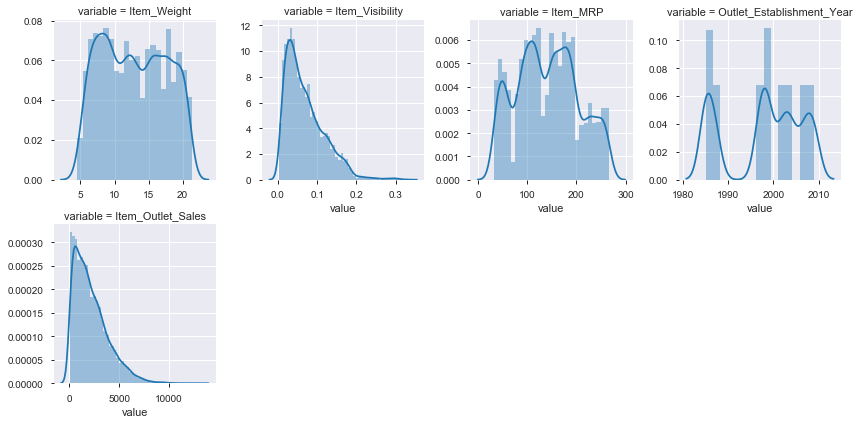

In [17]:
plot_histograms(train_num_df)

#### Inferences on Numeric columns

>- **Item_Weight**: Doesn't have uniform distribution as it depends type of item 
- **Item_Visibility**: Right skewed distribution,check if we need to apply power transformation to reduce the skewness
- **Item_MRP**: Doesn't have uniform distribution as it depends type of item
- **Item_Outlet_Sales**: Check if we need apply any log transformation 


#### Univariate Analysis - Categorical Variables

In [18]:
exclude_cols  = list(train_num_df.columns)
exclude_cols.append('Item_Identifier')
qualitative = [col for col in train_df.columns if col not in  exclude_cols] 

In [19]:
for column in qualitative:
    train_df[column] = train_df[column].astype('category')
    if train_df[column].isnull().any():
        train_df[column] = train_df[column].cat.add_categories(['MISSING'])
        train_df[column] = train_df[column].fillna('MISSING')

In [20]:
def plot_countplot(df):
    f = pd.melt(df) 
    g = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
    g.set_xticklabels(rotation=90)
    g = g.map(sns.countplot, 'value')
    
    return g

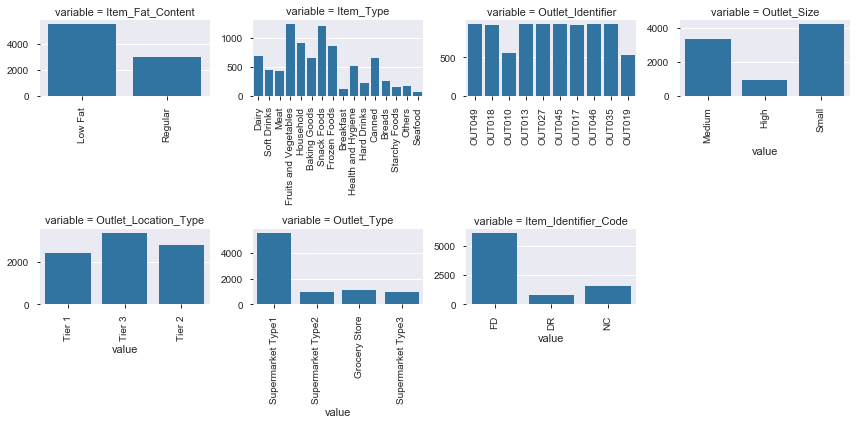

In [21]:
plot_countplot(train_df[qualitative])

####  Bi-variate Analysis  Categorical vs Target

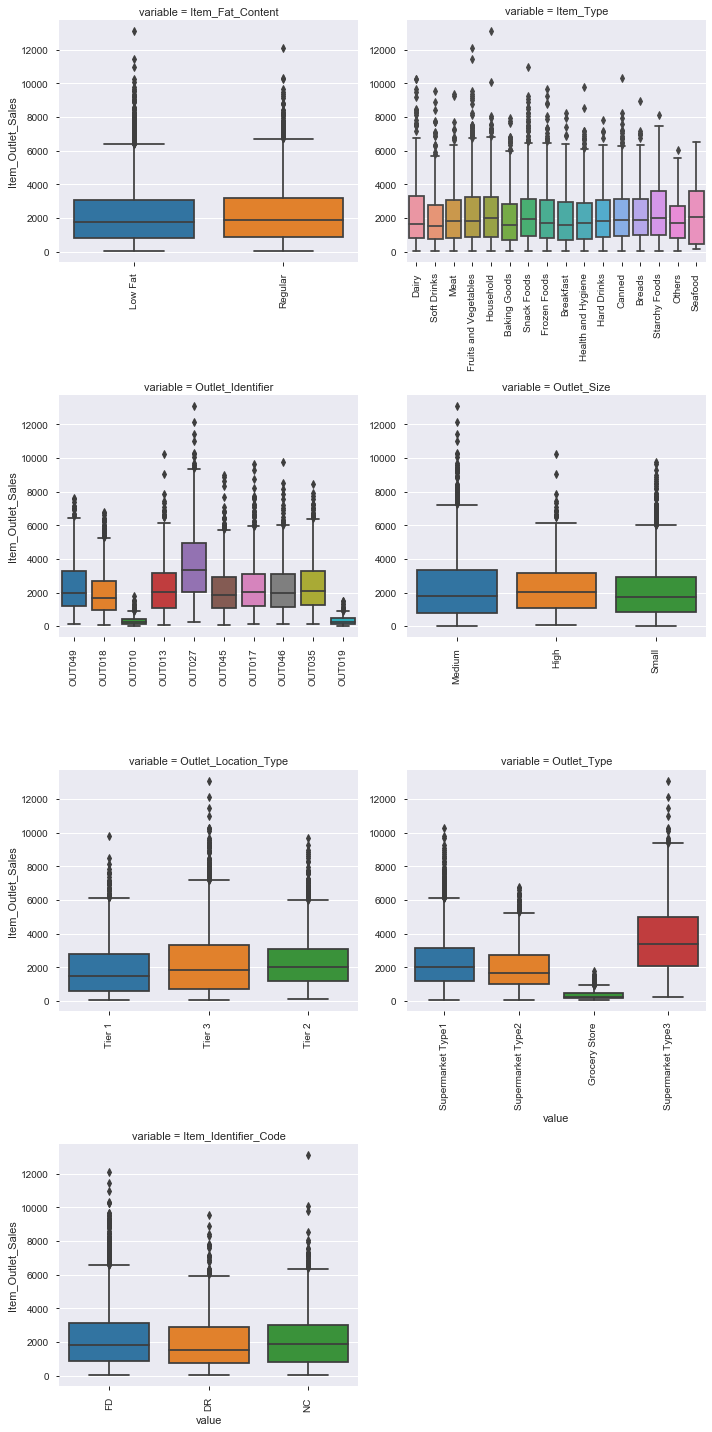

In [22]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(train_df, id_vars=['Item_Outlet_Sales'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "Item_Outlet_Sales")

#### Inferences  from categorical variables
> - **Outlet_Type**: Supermarket Type3 has high sales  and Grocery Store  has lowest sales
- **Outlet_Location_Type**: Tier3 has marginally good Item Outlet_Sales


In [23]:
items_group = train_df.groupby(['Outlet_Identifier'])['Item_Outlet_Sales'].agg(
    sales_avg=pd.NamedAgg(column = 'Item_Outlet_Sales',aggfunc='sum')
).reset_index()

In [24]:
items_type_group = train_df.groupby(['Outlet_Type'])['Item_Outlet_Sales'].agg(
sales_avg=pd.NamedAgg(column = 'Outlet_Type_Sales',aggfunc='mean')
).reset_index()

In [25]:
items_type_group

,Outlet_Type,sales_avg
0,Grocery Store,339.8285
1,Supermarket Type1,2316.1811
2,Supermarket Type2,1995.4987
3,Supermarket Type3,3694.0386


In [26]:
train_num_df = train_df.select_dtypes(include=['float64','int64'])
train_num_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.3000,0.0160,249.8092,1999,3735.1380
1,5.9200,0.0193,48.2692,2009,443.4228
2,17.5000,0.0168,141.6180,1999,2097.2700
3,19.2000,0.0153,182.0950,1998,732.3800
4,8.9300,0.0081,53.8614,1987,994.7052


In [27]:
train_df.groupby(['Item_Fat_Content'])['Item_Outlet_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Fat_Content,,,,,,,,
Low Fat,5517.0000,2157.7115,1697.9738,33.2900,826.2578,1765.0358,3050.6956,13086.9648
Regular,3006.0000,2224.5612,1721.4809,33.9558,857.5504,1844.5989,3198.6697,12117.5600


In [28]:
item_type  = train_df.groupby(['Outlet_Type','Item_Type'])['Item_Outlet_Sales'].describe().reset_index()
item_type = item_type.sort_values(['mean'], ascending=False)
item_type

,Outlet_Type,Item_Type,count,mean,std,min,25%,50%,75%,max
50,Supermarket Type3,Breakfast,11.0000,4584.7593,2552.0752,1518.0240,2670.8567,3866.9664,7137.0431,8209.3140
54,Supermarket Type3,Fruits and Vegetables,140.0000,4114.4871,2249.1649,417.4566,2284.8592,3996.7974,5308.5899,12117.5600
52,Supermarket Type3,Dairy,67.0000,3915.1822,2426.2771,905.4880,1943.8031,3435.5280,5462.2232,10236.6750
58,Supermarket Type3,Meat,56.0000,3862.2939,2179.4904,641.8312,2091.1113,3300.0377,5475.0399,9390.4432
57,Supermarket Type3,Household,99.0000,3821.2078,2261.4812,293.6178,2120.5730,3419.5488,5063.7419,13086.9648
...,...,...,...,...,...,...,...,...,...,...
15,Grocery Store,Starchy Foods,13.0000,300.1222,228.8079,58.5904,164.4526,185.0924,370.1848,852.2240
0,Grocery Store,Baking Goods,85.0000,292.0825,198.6280,37.2848,143.8128,223.7088,392.8220,792.3020
11,Grocery Store,Others,27.0000,288.0941,220.1813,39.9480,144.8115,214.3876,374.8454,815.6050
7,Grocery Store,Hard Drinks,24.0000,243.1557,194.5147,37.9506,100.2029,145.8102,394.4865,756.3488


In [29]:
location_size = train_df.groupby(['Outlet_Size','Outlet_Location_Type'])['Item_Outlet_Sales'].describe().reset_index()
location_size = location_size.sort_values(['mean'], ascending=False)
location_size

,Outlet_Size,Outlet_Location_Type,count,mean,std,min,25%,50%,75%,max
1,Medium,Tier 1,930.0000,2348.3546,1513.2895,111.8544,1182.7937,1966.1074,3281.7282,7646.0472
4,Small,Tier 2,2785.0000,2323.9906,1520.5435,99.8700,1171.8080,2004.0580,3110.6176,9664.7528
0,High,Tier 3,932.0000,2298.9953,1533.5317,73.2380,1072.6038,2050.6640,3166.3783,10256.6490
2,Medium,Tier 3,2418.0000,2272.1626,2040.0350,33.2900,589.7323,1698.7887,3397.5774,13086.9648
3,Small,Tier 1,1458.0000,1576.1929,1517.5231,33.9558,369.6855,1040.6454,2396.8800,9779.9362


In [30]:
# 3 way cross table
 
pd.crosstab([train_df['Outlet_Type'], train_df['Outlet_Size']],train_df['Item_Type'], margins=True)

Item_Type                      Baking Goods  Breads  Breakfast  Canned  Dairy  \
Outlet_Type       Outlet_Size                                                   
Grocery Store     Medium                 42      17          9      35     43   
                  Small                  43      16         10      38     49   
Supermarket Type1 High                   73      25         13      65     80   
                  Medium                 66      25         13      67     78   
                  Small                 287     110         42     294    292   
Supermarket Type2 Medium                 68      27         12      78     73   
Supermarket Type3 Medium                 69      31         11      72     67   
All                                     648     251        110     649    682   

Item_Type                      Frozen Foods  Fruits and Vegetables  \
Outlet_Type       Outlet_Size                                        
Grocery Store     Medium                 54                     79   
                  Small                  49                     73   
Supermarket Type1 High                   92                    142   
                  Medium                 93                    138   
                  Small                 387                    525   
Supermarket Type2 Medium                 92                    135   
Supermarket Type3 Medium                 89                    140   
All                                     856                   1232   

Item_Type                      Hard Drinks  Health and Hygiene  Household  \
Outlet_Type       Outlet_Size                                               
Grocery Store     Medium                16                  37         67   
                  Small                  8                  30         52   
Supermarket Type1 High                  23                  61        103   
                  Medium                30                  52         95   
                  Small                 92                 222        399   
Supermarket Type2 Medium                22                  58         95   
Supermarket Type3 Medium                23                  60         99   
All                                    214                 520        910   

Item_Type                      Meat  Others  Seafood  Snack Foods  \
Outlet_Type       Outlet_Size                                       
Grocery Store     Medium         34      10        4           71   
                  Small          32      17        6           75   
Supermarket Type1 High           41      16        5          125   
                  Medium         47      17        7          139   
                  Small         169      74       28          521   
Supermarket Type2 Medium         46      20        7          132   
Supermarket Type3 Medium         56      15        7          137   
All                             425     169       64         1200   

Item_Type                      Soft Drinks  Starchy Foods   All  
Outlet_Type       Outlet_Size                                    
Grocery Store     Medium                28              9   555  
                  Small                 26              4   528  
Supermarket Type1 High                  49             19   932  
                  Medium                46             17   930  
                  Small                205             68  3715  
Supermarket Type2 Medium                46             17   928  
Supermarket Type3 Medium                45             14   935  
All                                    445            148  8523

####  ChiSquare Test

In [31]:
ct = ChiSquare(train_df)
#Feature Selection
for var in qualitative:
    ct.test_chi2(colX=var,colY=target )  

Item_Fat_Content is IMPORTANT for Prediction
Item_Type is IMPORTANT for Prediction
Outlet_Identifier is IMPORTANT for Prediction
Outlet_Size is NOT an important predictor. (Discard Outlet_Size from model)
Outlet_Location_Type is IMPORTANT for Prediction
Outlet_Type is IMPORTANT for Prediction
Item_Identifier_Code is IMPORTANT for Prediction


#### Anova
>**ANOVA**:- It assesses whether the average of more than two groups is statistically different.

<module 'matplotlib.pyplot' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

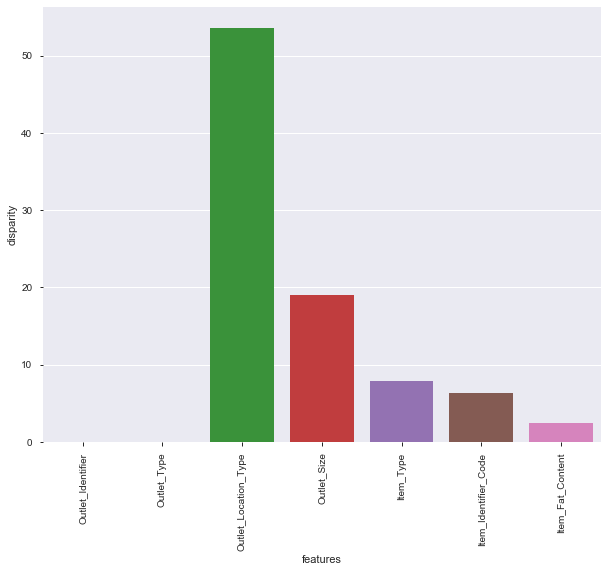

In [32]:
from scipy import stats
def anova(frame,categorical_features,target):
    anv = pd.DataFrame()
    anv['features'] = categorical_features
    pvals = []
    for c in categorical_features:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls][target].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

 
k = anova(train_df,qualitative,target) 
k['disparity'] = np.log(1./k['pval'].values) 

plt.figure(figsize=(10,8))
sns.barplot(data=k, x = 'features', y='disparity') 
plt.xticks(rotation=90) 
plt 

#### Encoding

In [33]:
def encode_to_map(df, col,target):
    named_agg_col = col+'_'+'sales'
    items_group = train_df.groupby([col])[target].agg(sales_avg=pd.NamedAgg(column=named_agg_col, aggfunc='sum')).reset_index()
    items_group =items_group.sort_values(['sales_avg'], ascending=False)
    return items_group.sort_values(['sales_avg'], ascending=False)[col].values 
    

def value_counts_to_map(df,col):
    return train_df[col].value_counts(sort=True,ascending=True).index.values
    

item_fat_content_map  = { k:v for v,k  in enumerate(value_counts_to_map(train_df,'Item_Fat_Content'))}
outlet_identifier_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Identifier',target))}
item_type_map  = { k:v for v,k  in enumerate(encode_to_map(train_df,'Item_Type',target))}
outlet_size_map ={ k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Size',target))}
outlet_type_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Type',target))}
location_Type_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Outlet_Location_Type',target))}
item_identifier_map = { k:v for v,k  in enumerate(encode_to_map(train_df,'Item_Identifier',target))} 

train_df['Item_Fat_Content'] = train_df['Item_Fat_Content'].map(item_fat_content_map)
train_df['Outlet_Identifier'] = train_df['Outlet_Identifier'].map(outlet_identifier_map)
train_df['Item_Type'] = train_df['Item_Type'].map(item_type_map)
train_df['Outlet_Size'] = train_df['Outlet_Size'].map(outlet_size_map)
train_df['Outlet_Type'] = train_df['Outlet_Type'].map(outlet_type_map)
train_df['Outlet_Location_Type'] = train_df['Outlet_Location_Type'].map(location_Type_map)
train_df['Item_Identifier'] = train_df['Item_Identifier'].map(item_identifier_map)


In [37]:
train_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Identifier_Code
0,1,9.3000,1,0.0160,4,249.8092,2,1999,1,2,0,3735.1380,FD
1,1267,5.9200,0,0.0193,9,48.2692,7,2009,1,0,2,443.4228,DR
2,813,17.5000,1,0.0168,8,141.6180,2,1999,1,2,0,2097.2700,FD
3,285,19.2000,0,0.0153,0,182.0950,8,1998,1,0,3,732.3800,FD
4,1395,8.9300,1,0.0081,2,53.8614,4,1987,2,0,0,994.7052,NC
